#  <center> Length Classification using FastAI. </center> 


___

For this dataset, I will create an length classifier which can distinguish between knee, mini, maxi, and tea length dresses for women using FastAI.

| Class | Description |
| --- | --- |
| Knee | Dress whose length is till the knee. |
| Mini | Dress whose length is above the knee. |
| Maxi | Dress whose length is till the floor level. |
| Tea  | Dress whose length is more than knee but less than maxi. |

I build this model in Google Collab as my jupyter notebook was crashing all the time.


## Mounting Google Drive:

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'

Hello Google Drive!

## Loading the Libraries:

In [0]:
from fastai.vision import *

In [0]:
from pathlib import Path

In [0]:
PATH = Path('/gdrive/My Drive/length/train')


## Loading in our data:


- Before any work can be done a dataset needs to be converted into a DataBunch object, and in the case of the computer vision data - specifically into an ImageDataBunch subclass.

- get_transforms returns a tuple of two lists of transforms: one for the training set and one for the validation set (we don't want to modify the pictures in the validation set, so the second list of transforms is limited to resizing the pictures). This can be passed directly to define a DataBunch object.

- image size is set to 224

- validation data is set to 20 %.

- num_workers is the number of CPUs to use,



In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(PATH, test='test', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


_Now we can use the data object to get more information about our data._


In [7]:
data.classes

['knee', 'maxi', 'mini', 'tea']

We can show a random batch of images using the show_batch method.


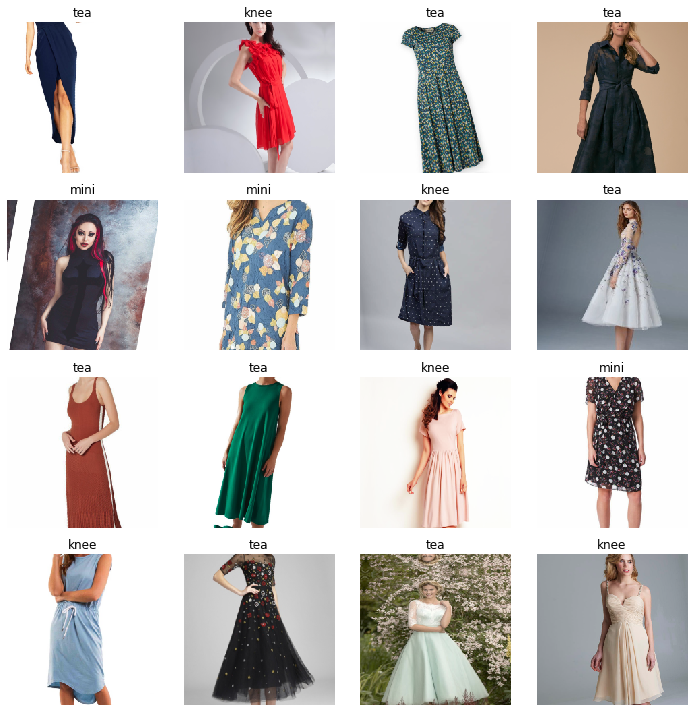

In [8]:
data.show_batch(rows=4, figsize=(10,10))


# Creating a model and initial training:

____
The method needs two arguments, the data, and the architecture, but also supports many other parameters that can be used to customize the model for a given problem.

- The created model uses the resnet34 architecture, with weights pretrained on the imagenet dataset.

- By default, only the fully connected layers at the top are unfrozen (can be trained), which if you are familiar with transfer learning makes perfect sense.




In [9]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.2MB/s]


<div class="alert alert-block alert-info"><b> 

_To train the layers we can use the fit or fit_one_cycle method. The fit method is the “normal” way of training a neural net with a constant learning rate, whilst the fit_one_cycle method uses something called the 1 cycle policy, which basically changes the learning rate over time to achieve better results._

</b></div>    


In [10]:
learn.fit_one_cycle(4)


epoch,train_loss,valid_loss,accuracy,time
0,1.762401,1.028650,0.629013,13:27
1,1.370500,0.770198,0.683710,12:53
2,1.067248,0.714227,0.703924,12:52
3,0.918765,0.699155,0.701546,12:53


<div class="alert alert-block alert-info"><b> 
    
_To find the perfect learning rates we can use the lr_find and recorder.plot methods which create a plot that relates the learning rate with the loss._

</b></div>    


In [0]:
learn.unfreeze() 



In [12]:
learn.lr_find()



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


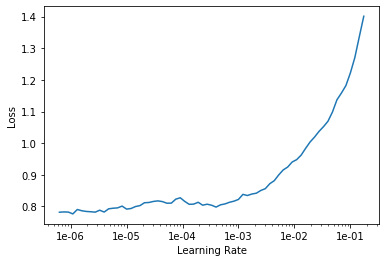

In [13]:
learn.recorder.plot()

Here we are searching for the point with the steepest downward slope that still has a high value, which in this case is around 3e-3.

To now train the model using differential learning rates we need to pass the max_lr argument to the fit_one_cycle method.


In [14]:
learn.fit_one_cycle(4, max_lr=slice(3e-4, 3e-3))


epoch,train_loss,valid_loss,accuracy,time
0,0.815707,0.963637,0.644471,17:16
1,0.745206,0.544830,0.766944,17:17
2,0.600221,0.451418,0.814507,17:17
3,0.476856,0.416004,0.834721,17:16


The model can now be saved using the save method & load using load method.


<div class="alert alert-block alert-info"><b>
    
_If you want to save the weights and load them up later. You can do that with learner.save and learner.load on an already instantiated learner instance._
</b></div>    


In [0]:
learn.save('stage-1') #- to save the model


In [16]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (3368 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
maxi,maxi,maxi,maxi,maxi
Path: /gdrive/My Drive/length/train;

Valid: LabelList (841 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
tea,maxi,knee,maxi,knee
Path: /gdrive/My Drive/length/train;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /gdrive/My Drive/length/train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

## Interpretation:

<div class="alert alert-block alert-info"><b>

_We can use FastAIs ClassificationInterpretation class to interpret our results. To create an interpretation object we need to call the from_learner method and pass it our learner/model. Then we can use methods like plot_confusion_matrix, plot_top_losses or most_confused._
</b></div>    



In [17]:
interp = ClassificationInterpretation.from_learner(learn)


### Plot top losses:


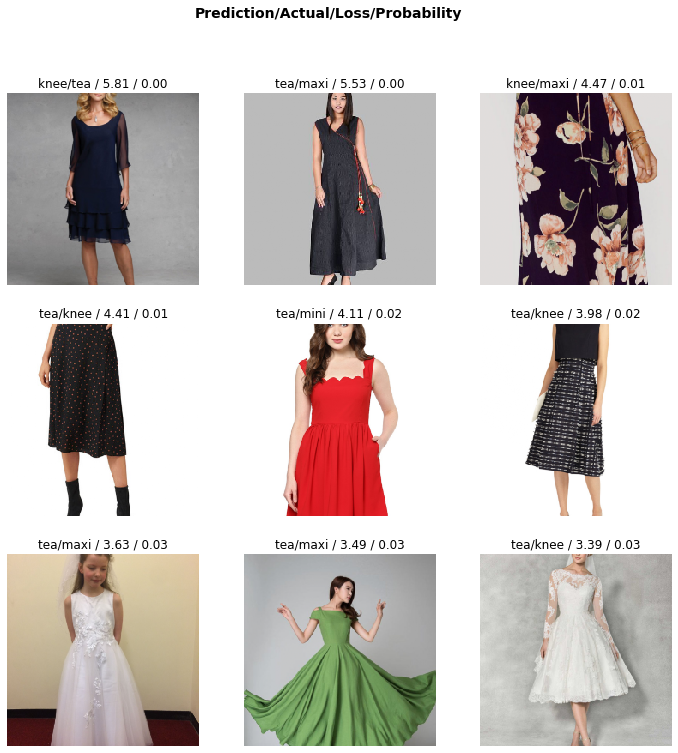

In [18]:
interp.plot_top_losses(9)


# Confusion Matrix:

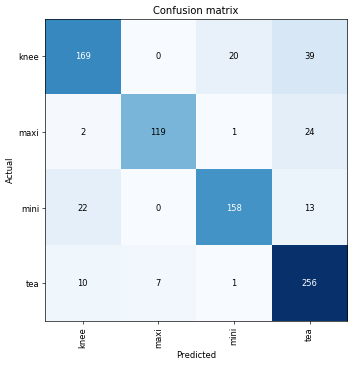

In [19]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)


In [20]:
interp.most_confused(min_val=2)


[('knee', 'tea', 39),
 ('maxi', 'tea', 24),
 ('mini', 'knee', 22),
 ('knee', 'mini', 20),
 ('mini', 'tea', 13),
 ('tea', 'knee', 10),
 ('tea', 'maxi', 7),
 ('maxi', 'knee', 2)]

# Predictions:

In [36]:
file = '/gdrive/My Drive/test/knee.jpg'
knee_img = open_image(file)
pred_knee = learn.predict(knee_img)
pred_knee

(Category knee,
 tensor(0),
 tensor([9.8947e-01, 8.7717e-04, 1.0970e-03, 8.5510e-03]))

In [33]:
file = '/gdrive/My Drive/test/maxi.jpg'
maxi_img = open_image(file)
pred_maxi = learn.predict(maxi_img)
pred_maxi

(Category maxi, tensor(1), tensor([0.0067, 0.7693, 0.0016, 0.2225]))

In [34]:
file = '/gdrive/My Drive/test/mini.jpg'
mini_img = open_image(file)
pred_mini = learn.predict(mini_img)
pred_mini

(Category mini,
 tensor(2),
 tensor([1.8547e-03, 1.2805e-04, 9.9798e-01, 3.4893e-05]))

In [37]:
file = '/gdrive/My Drive/test/tea.jpg'
tea_img = open_image(file)
pred_tea = learn.predict(tea_img)
pred_tea

(Category tea,
 tensor(3),
 tensor([9.8362e-04, 1.1423e-03, 6.1391e-05, 9.9781e-01]))

In [0]:
knee = [pred_knee]
mini = [pred_mini]
maxi = [pred_maxi]
tea = [pred_tea]

In [0]:
import pandas as pd
import numpy as np

In [0]:
Predictons = pd.DataFrame([knee, mini, maxi, tea], columns = ['Category'], index = ['Knee_length', 'Mini_length', 'Maxi_length', 'Tea_length'])

In [49]:
Predictons

,Category
Knee_length,"(knee, tensor(0), [tensor(0.9895), tensor(0.00..."
Mini_length,"(mini, tensor(2), [tensor(0.0019), tensor(0.00..."
Maxi_length,"(maxi, tensor(1), [tensor(0.0067), tensor(0.76..."
Tea_length,"(tea, tensor(3), [tensor(0.0010), tensor(0.001..."


## Key Points:
<div class="alert alert-block alert-info"><b>
    
- In the 1st fit_one_cylce I got the around 70 % accuracy.
- After find learning rate and doing max slicing I got 83 % mere increase in 13 %.
- On the Unseen data the predictions made were correct on all the category.
                                             
</b></div>    
